## Data Generation

In [382]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import expon
# This might be new, can install via
# conda install -c conda-forge lifelines **OR** pip install lifelines
from lifelines import KaplanMeierFitter
from lifelines.utils import datetimes_to_durations

Let's generate some fake data! We will start by assuming that 100 employees are hired on Jan 1st 2017 for two companies, `GoodCo` and `BadCo`. The employees at `GoodCo` have a 0.05% chance of leaving per day, while those at `BadCo` have a 0.08% chance of leaving per day.

We are going to track how many left over 3 months, and what the distribution of leaving times look like

In [565]:
np.random.seed(36)

time_to_quit_Good = np.floor(expon(scale=1/0.0005).rvs(size=1000))
time_to_quit_Bad = np.floor(expon(scale=1/0.0008).rvs(size=1000))

MAX_TIME = 90

In [566]:
np.median(time_to_quit_Good), np.median(time_to_quit_Bad)

(1332.5, 927.0)

But we are only observing for 3 months (i.e. 90 days), so anyone that takes longer than 90 days to quit won't have a quit date.

In [567]:
time_to_quit_Good[time_to_quit_Good > MAX_TIME] = np.nan
time_to_quit_Bad[time_to_quit_Bad > MAX_TIME] = np.nan

In [568]:
alias = {'Good': 'A', 'Bad': 'B'}
employees = pd.DataFrame({'duration_employment': np.concatenate([time_to_quit_Good, time_to_quit_Bad]),
                          'join_date': pd.to_datetime('2017-01-01'),
                          'company': ['A'] * len(time_to_quit_Good) + ['B'] * len(time_to_quit_Bad)
                         }
                        )
employees['quit_date'] = employees.join_date + pd.to_timedelta(employees.duration_employment, unit='d')
employees = employees[['company', 'join_date', 'quit_date', 'duration_employment']]

In [569]:
employees.sample(10, random_state=562)

,company,join_date,quit_date,duration_employment
1699,B,2017-01-01,NaT,NaN
470,A,2017-01-01,NaT,NaN
2,A,2017-01-01,NaT,NaN
1932,B,2017-01-01,NaT,NaN
1074,B,2017-01-01,2017-02-09,39.0
1173,B,2017-01-01,2017-04-01,90.0
888,A,2017-01-01,NaT,NaN
812,A,2017-01-01,NaT,NaN
245,A,2017-01-01,NaT,NaN
72,A,2017-01-01,NaT,NaN


In [570]:
employees.to_csv('generated_employee_retention_data.csv')

## Using data

In [571]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import expon
# This might be new, can install via
# conda install -c conda-forge lifelines **OR** pip install lifelines
from lifelines import KaplanMeierFitter
from lifelines.utils import datetimes_to_durations

In [572]:
employees = pd.read_csv('generated_employee_retention_data.csv', parse_dates=['join_date', 'quit_date'])

In [573]:
employees.groupby('company').duration_employment.mean()

company
A    38.047619
B    48.580645
Name: duration_employment, dtype: float64

In [574]:
employees.groupby('company').duration_employment.median()

company
A    37.5
B    49.0
Name: duration_employment, dtype: float64

In [575]:
employees.groupby('company').duration_employment.count()

company
A    42
B    62
Name: duration_employment, dtype: int64

## Looking at only those that have left

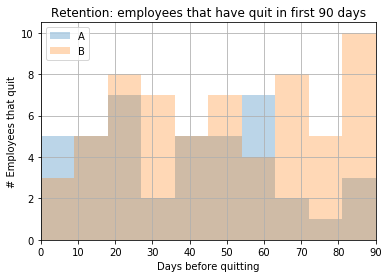

In [576]:
for company_name, company in employees.groupby('company'):
    company.duration_employment.hist(alpha=0.3, label=company_name, 
                                     range=(0,90), bins=10)
plt.title("Retention: employees that have quit in first 90 days")
plt.xlim(0, 90)
plt.xlabel('Days before quitting')
plt.ylabel('# Employees that quit')
plt.legend()


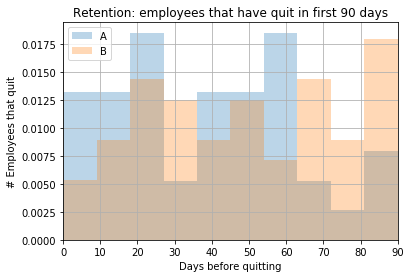

In [577]:
for company_name, company in employees.groupby('company'):
    company.duration_employment.hist(alpha=0.3, label=company_name, 
                                     range=(0,90), bins=10, density=True)
plt.title("Retention: employees that have quit in first 90 days")
plt.xlim(0, 90)
plt.xlabel('Days before quitting')
plt.ylabel('# Employees that quit')
plt.legend()

## What would using lifelines tells us?

In [578]:
kmf = KaplanMeierFitter()

In [579]:
company_A = employees[employees.company == 'A']
kmf.fit(company_A.duration_employment.fillna(MAX_TIME), ~company_A.duration_employment.isna())

<lifelines.KaplanMeierFitter: fitted with 1000 observations, 958 censored>

In [580]:
kmf.median_

inf

In [581]:
kmf.survival_function_[kmf.survival_function_.KM_estimate < 0.97].index[0]

54.0

In [582]:
company_B = employees[employees.company == 'B']
kmf.fit(company_B.duration_employment.fillna(MAX_TIME), ~company_B.duration_employment.isna())
kmf.median_

inf

In [583]:
kmf.survival_function_[kmf.survival_function_.KM_estimate < 0.97].index[0]

48.0

Text(0,0.5,'Prob survival')

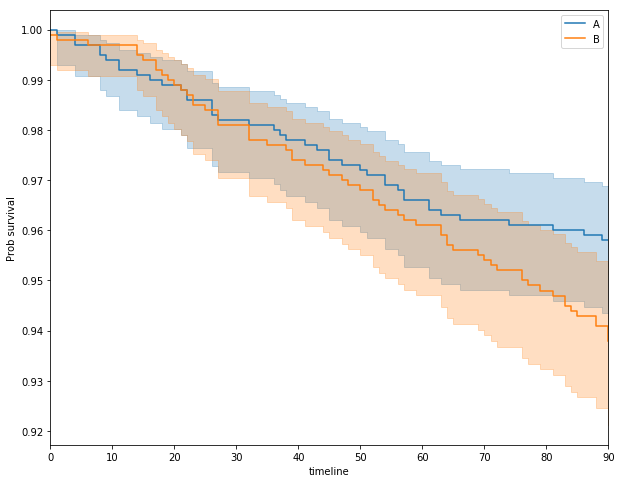

In [585]:
plt.figure(figsize=(10,8))
ax = plt.gca()
medians = {}
show_median = False

for company_name, company in employees.groupby('company'):
    kmf.fit(company.duration_employment.fillna(MAX_TIME), ~company.duration_employment.isna(), 
            label=company_name)
    ax = kmf.plot(ax=ax)
    medians[company_name] = kmf.median_
    
if medians['B'] < float('inf'):
    ax.axvline(medians['B'], color='orange', ls='--')
    show_median = True
    
if medians['A'] < float('inf'):
    ax.axvline(medians['A'], color='blue', ls='--')
    show_median = True
    
if show_median:
    ax.axhline(0.5, color='k', ls='--')

plt.ylabel('Prob survival')

In [561]:
3 < float('inf')

True

## Reconstruct metis, as best I can

In [591]:
f="""
Name,join,quit
Sophie,09-2017,
Roberto,04-2018,
Zach,03-2017,2018-11
Robert,03-2018,03-2019
Lara,06-2018,
Seth,04-2017,03-2018
Damien,03-2018,04-2019
JB,03-2017,
Michelle,01-2016,01-2017
Chad,01-2018,
Brendan,03-2018,03-2019
Adam,09-2018,
Kimberly,11-2018,
Cliff,11-2018,
Julia,7-2015,10-2018
Alice,7-2017,
David,3-2017,8-2018
"""

In [592]:
from io import StringIO

In [595]:
emp_metis = pd.read_csv(StringIO(f), parse_dates=['join', 'quit'])

In [597]:
emp_metis['duration'] = (emp_metis['quit'] - emp_metis['join']).dt.days

In [598]:
emp_metis

,Name,join,quit,duration
0,Sophie,2017-09-01,NaT,NaN
1,Roberto,2018-04-01,NaT,NaN
2,Zach,2017-03-01,2018-11-01,610.0
3,Robert,2018-03-01,2019-03-01,365.0
4,Lara,2018-06-01,NaT,NaN
5,Seth,2017-04-01,2018-03-01,334.0
6,Damien,2018-03-01,2019-04-01,396.0
7,JB,2017-03-01,NaT,NaN
8,Michelle,2016-01-01,2017-01-01,366.0
9,Chad,2018-01-01,NaT,NaN


In [599]:
emp_metis.duration.median(), emp_metis.duration.mean()

(381.0, 517.75)

In [600]:
emp_metis['duration'] = (emp_metis['quit'].fillna(pd.to_datetime('2019-07-14')) - emp_metis['join']).dt.days
emp_metis.duration.median(), emp_metis.duration.mean()

(408.0, 511.3529411764706)

In [601]:
kmf = KaplanMeierFitter()
kmf.fit(emp_metis.duration, ~emp_metis.quit.isna())

<lifelines.KaplanMeierFitter: fitted with 17 observations, 9 censored>

In [606]:
!cat /anaconda3/lib/python3.6/site-packages/lifelines/fitters/kaplan_meier_fitter.py

# -*- coding: utf-8 -*-
from __future__ import print_function
from __future__ import division
import warnings
import numpy as np
import pandas as pd

from lifelines.fitters import UnivariateFitter
from lifelines.utils import _preprocess_inputs, _additive_estimate, StatError, inv_normal_cdf,\
    median_survival_times, check_nans_or_infs
from lifelines.plotting import plot_loglogs


class KaplanMeierFitter(UnivariateFitter):

    """
    Class for fitting the Kaplan-Meier estimate for the survival function.

    KaplanMeierFitter(alpha=0.95)

    alpha: The alpha value associated with the confidence intervals.

    """

    def fit(self, durations, event_observed=None, timeline=None, entry=None, label='KM_estimate',
            alpha=None, left_censorship=False, ci_labels=None, weights=None):
        """
        Parameters:
          duration: an array, or pd.Series, of length n -- duration subject was observed for
          timeline: return the best estimate at the values in timelines 

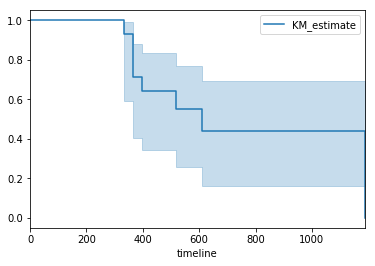

In [602]:
kmf.plot()

In [603]:
kmf.median_

610.0

In [402]:
emps = pd.read_csv('employee_retention_data.csv', parse_dates=['join_date', 'quit_date'])

In [403]:
emps.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [139]:
emps['days_in_job'] = (emps['quit_date'] - emps['join_date']).dt.days
emps['has_left'] = ~emps['quit_date'].isna()

In [140]:
emps.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,days_in_job,has_left
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0,True
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0,True
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaN,False
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0,True
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0,True


To simplify the analysis, we will look at two companies: `company_id` 1 and `company_id` 3

In [182]:
company_1 = emps[emps.company_id==1].copy()
company_3 = emps[emps.company_id==9].copy()

## For each company, what is the median time in the job?

We can look at the median of the days before leaving. This means that we will be dropping everyone that is currently working, as we don't have an end date for those people yet. We can also see that this is a right skewed distribution.

In [183]:
company_1.days_in_job.median(), company_1.days_in_job.mean(), \
company_3.days_in_job.median(), company_3.days_in_job.mean()

(417.0, 616.1488855226141, 431.0, 622.1417769376181)

What does the distribution look like? Again, we have to remember th

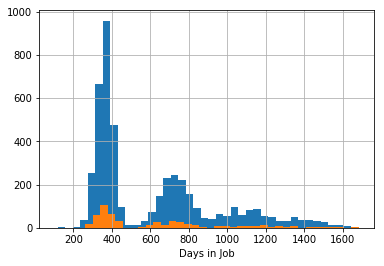

In [184]:
company_1.days_in_job.hist(bins=40);
company_3.days_in_job.hist(bins=40);

plt.xlabel('Days in Job');


In [185]:
latest = max(emps.join_date.max(), emps.quit_date.max())
latest

Timestamp('2015-12-10 00:00:00')

In [186]:
company_1.has_left.mean(), company_3.has_left.mean()

(0.5445439547489983, 0.5504682622268471)

## Calculate the median assuming everyone currently there left today

In [187]:
today = max(emps.quit_date.max(), emps.join_date.max())
today

Timestamp('2015-12-10 00:00:00')

In [188]:
company_1['imputed_days_duration'] = (company_1.quit_date.fillna(today) - company_1.join_date).dt.days
company_3['imputed_days_duration'] = (company_3.quit_date.fillna(today) - company_3.join_date).dt.days


In [189]:
company_1.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,days_in_job,has_left,imputed_days_duration
9,504159.0,1,sales,7,104000.0,2012-06-12,NaT,NaN,False,1276
12,939058.0,1,marketing,1,48000.0,2012-12-10,2013-11-15,340.0,True,340
15,265226.0,1,data_science,4,80000.0,2014-05-27,2015-07-10,409.0,True,409
19,982668.0,1,customer_service,14,76000.0,2015-07-27,NaT,NaN,False,136
28,888375.0,1,customer_service,5,75000.0,2011-08-01,2013-10-04,795.0,True,795


What is the median and mean duration, if we use the imputed values?

In [190]:
company_1.imputed_days_duration.median(), company_1.imputed_days_duration.mean(), \
company_3.imputed_days_duration.median(), company_3.imputed_days_duration.mean()

(429.0, 576.7479377798727, 424.0, 567.7502601456816)

## Using distributional properties

In [191]:
kmf = KaplanMeierFitter()
kmf.fit(company_1['imputed_days_duration'], event_observed=company_1['has_left'])
kmf.median_

739.0

In [192]:
kmf.fit(company_3['imputed_days_duration'], event_observed=company_3['has_left'])
kmf.median_

732.0

In [193]:
mask = (kmf.survival_function_ < 0.5) # [kmf.survival_function_ < 0.5]
tf = kmf.survival_function_
tf[tf.KM_estimate<0.5].head()

,KM_estimate
timeline,
732.0,0.490374
735.0,0.488584
736.0,0.486794
738.0,0.484998
739.0,0.479569


In [21]:
import lifelines
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [22]:
emps = pd.read_csv('employee_retention_data.csv')
emps['join_date'] = pd.to_datetime(emps['join_date'])
emps['quit_date'] = pd.to_datetime(emps['quit_date'])

In [23]:
emps.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [24]:
emps['observed'] = (~emps['quit_date'].isna())
emps['duration'] = (emps['quit_date'].fillna(emps['quit_date'].max()) - emps['join_date'])
emps.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,observed,duration
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,True,585 days
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,True,340 days
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,False,422 days
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,True,389 days
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,True,1040 days


In [25]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(emps['duration'].dt.days, event_observed=emps['observed'])

<lifelines.KaplanMeierFitter: fitted with 24702 observations, 11192 censored>

In [29]:
kmf.median_

732.0

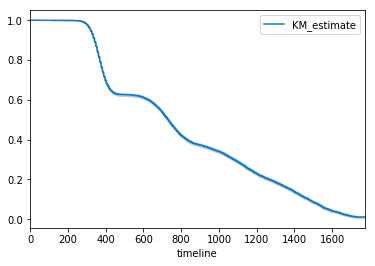

In [27]:
kmf.plot()

Company 1 has a median of 738.0 days of employment (naive medians are 417.0 and 429.0)
Company 2 has a median of 758.0 days of employment (naive medians are 430.5 and 431.0)
Company 3 has a median of 711.0 days of employment (naive medians are 420.0 and 416.0)
Company 4 has a median of 717.0 days of employment (naive medians are 415.0 and 417.0)
Company 5 has a median of 704.0 days of employment (naive medians are 417.0 and 421.0)
Company 6 has a median of 724.0 days of employment (naive medians are 413.0 and 417.0)
Company 7 has a median of 723.0 days of employment (naive medians are 424.0 and 442.0)
Company 8 has a median of 711.0 days of employment (naive medians are 403.0 and 410.0)
Company 9 has a median of 732.0 days of employment (naive medians are 431.0 and 424.0)
Company 10 has a median of 711.0 days of employment (naive medians are 410.0 and 406.0)
Company 11 has a median of 536.0 days of employment (naive medians are 392.0 and 482.0)
Company 12 has a median of 662.0 days of 

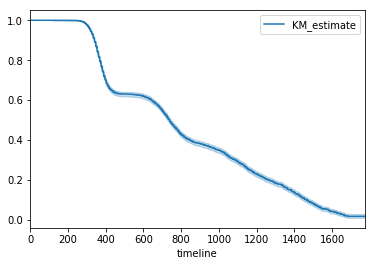

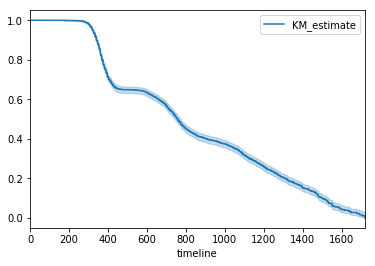

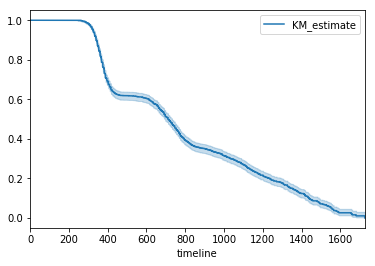

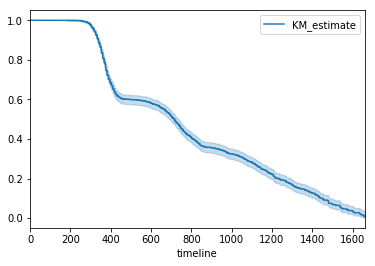

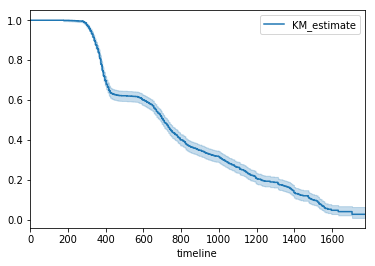

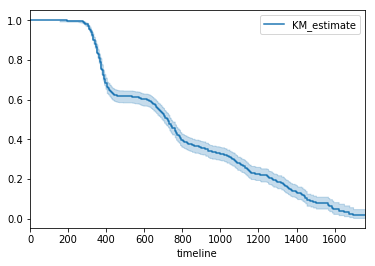

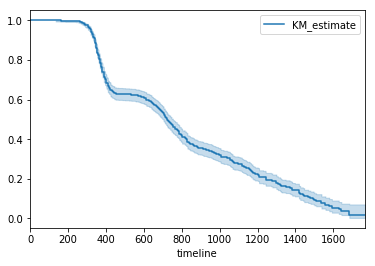

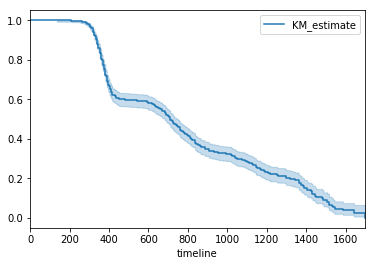

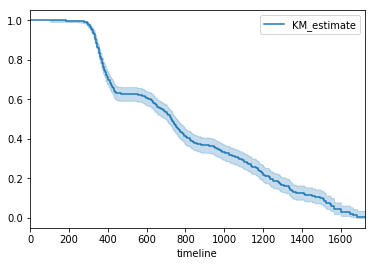

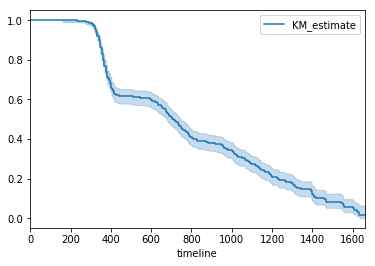

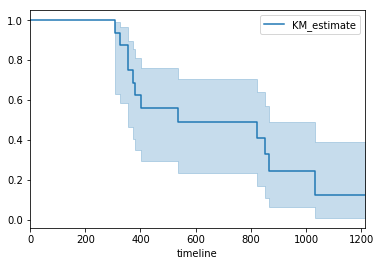

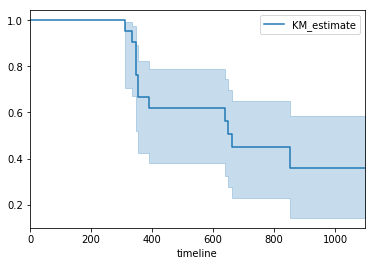

In [41]:
for company_id, company in emps.groupby('company_id'):
    kmf.fit(company['duration'].dt.days, event_observed=company['observed'])
    naive_median_quit = company[company.observed].duration.dt.days.median()
    naive_median_all = company.duration.dt.days.median()
    print(f"Company {company_id} has a median of {kmf.median_} days of employment (naive medians are {naive_median_quit} and {naive_median_all})")
    kmf.plot()
    
def get_inferred_median(company):
    kmf.fit(company['duration'].dt.days, event_observed=company['observed'])
    return kmf.median_

def get_naive_median_only_left(company):
    return company[company.observed].duration.dt.days.median()

def get_naive_median_all(company):
    return company.duration.dt.days.median()

company_df = pd.DataFrame(emps.groupby('company_id').apply(get_inferred_median), columns=['KMF median'])

In [50]:
company_df['naive_only_left'] = emps.groupby('company_id').apply(get_naive_median_only_left)
company_df['naive_only_all'] = emps.groupby('company_id').apply(get_naive_median_all)

company_df.rank()

,KMF median,naive_only_left,naive_only_all
company_id,,,
1,11.0,7.5,8.0
2,12.0,11.0,9.0
3,5.0,9.0,3.0
4,7.0,6.0,4.5
5,3.0,7.5,6.0
6,9.0,5.0,4.5
7,8.0,10.0,10.0
8,5.0,3.0,2.0
9,10.0,12.0,7.0


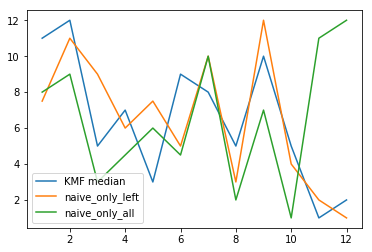

In [51]:
for c in company_df.columns:
    plt.plot(c, data=company_df.rank(), label=c)
plt.legend()

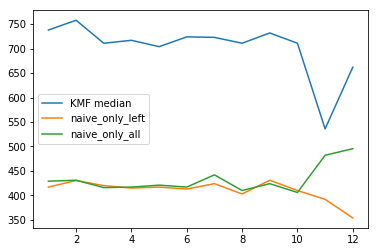

In [52]:
for c in company_df.columns:
    plt.plot(c, data=company_df, label=c)
plt.legend()

In [14]:
from lifelines.datasets import load_waltons
df = load_waltons() # returns a Pandas DataFrame

print(df.head())

      T  E    group
0   6.0  1  miR-137
1  13.0  1  miR-137
2  13.0  1  miR-137
3  13.0  1  miR-137
4  19.0  1  miR-137


In [16]:
T = df['T']
E = df['E']

from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)  # or, more succinctly, kmf.fit(T, E)

<lifelines.KaplanMeierFitter: fitted with 163 observations, 7 censored>

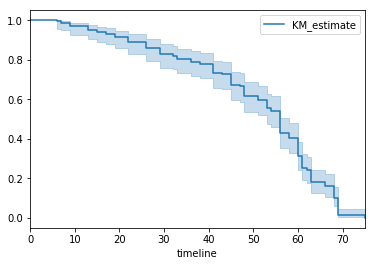

In [19]:
kmf.plot_survival_function_()

In [53]:
df

,T,E,group
0,6.0,1,miR-137
1,13.0,1,miR-137
2,13.0,1,miR-137
3,13.0,1,miR-137
4,19.0,1,miR-137
5,19.0,1,miR-137
6,19.0,1,miR-137
7,26.0,1,miR-137
8,26.0,1,miR-137
9,26.0,1,miR-137
